## Inference over a planar robotic arm - edit
This model implements a state-space model for rigid body dynamics of the robotic arm.

Our state-space $\mathbf{x} \in \mathbb{R}^6 $ includes torques $\tau_i$, angles $\theta_i$ and angular velocities $\dot{\theta}_i$. We append all static parameters in $\phi = \{L_{1}, L_{2}, M_{1}, M_{2}\}$.

$$
\mathbf{x} = \begin{pmatrix} \mathbf{x}_1 = \tau_1 \\  \mathbf{x}_2 = \tau_2 \\ \mathbf{x}_3 =\theta_1 \\ \mathbf{x}_4 =\theta_2 \\
\mathbf{x}_5 = \dot{\theta}_1 \\ \mathbf{x}_6 = \dot{\theta}_2 \end{pmatrix}, \quad \mathbf{\dot{x}} = \begin{pmatrix} 0 \\  0 \\ \mathbf{x}_5 \\ \mathbf{x}_6 \\ \mathbf{D}^{-1}(\mathbf{x}_4, \phi) [\begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix} - \mathbf{c}(\mathbf{x}_3, \mathbf{x}_4) -\mathbf{h}(\mathbf{x}_4, \mathbf{x}_5, \mathbf{x}_6) ]
\end{pmatrix}  := a(\mathbf{x})
$$

Where $\mathbf{D} \in \mathbb{R}^{2 \times 2}$ is the inertia tensor and $\mathbf{c},\mathbf{h} \in \mathbb{R}^{2}$ are gravity and fictitious forces vectors, respectively.

Note that $a(\mathbf{x})$ is non-linear because (1) the operation $\mathbf{D}^{-1}(\mathbf{x}_4, \phi) \begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix}$, and (2) $\mathbf{c},\mathbf{h}$ are non-linear functions of the state.

with noise on the torque

$$
\mathbf{\dot{x}} = a(\mathbf{x}) + \begin{pmatrix} 1 \\ 1 \\ 0 \\ 0\\0\\0\end{pmatrix} \nu, \quad \nu \sim \mathcal{N}(0,1)
$$

with Euler discretizetion 

$$
\mathbf{x}_{t+\Delta{t}} = \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ 0 \\ 0 \\ 0 \\0 \end{pmatrix} \nu_t \approx \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ \sigma \\ \sigma \\ \sigma \\\sigma \end{pmatrix} \nu_t
 $$

where we introduce $\sigma<<\Delta{t}$ to avoid a degenerate distribution.
So our transition is defined as follows:

$$
f(\mathbf{x}_{t+\Delta{t}}|\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_t + \Delta{t}a(\mathbf{x}_t), \text{diag}(\Delta{t}^2,\Delta{t}^2, \sigma, \sigma, \sigma, \sigma))
$$

The emission is 

$$
g(\mathbf{y}_t | \mathbf{x}_t) = \text{FW-KIN}(\mathbf{x}_3, \mathbf{x}_4)
$$

## Concepts Explored in this notebook
The full model from torques to coordinates $\mathbf{\tau} \rightarrow \mathbf{y}$ can be estimated properly with enough independent SMC samplers. In this implementation, the batch dimension of each tensor is used as an independent SMC sampler.

For parameter learning $\theta : = \{M_1, M_2, L_1, L_2\}$, we do not need to use SMC samplers; `batch_size` could be small, even 1. in each SGD iteration, I estimate the states $\mathbf{x}$. Some SGD iterations will be good and some bad, but we assume that they're good enough. Then, offline, we use many independent particle filters.

In [1]:
import os
import inspect
print(os.getcwd())
plot_folder = 'planar_arm_dyn_plots'

/home/ubuntu/aesmc/test


In [2]:
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)

In [3]:
parent_dir

'/home/ubuntu/aesmc'

In [4]:
# change dir to import from aesmc
os.chdir(parent_dir)
import aesmc.statistics as statistics
import aesmc.inference as inference
import aesmc.train as train
import aesmc.losses as losses
import aesmc.state as state
import aesmc.math as math
import aesmc.smoothing as smoothing

In [5]:
# change dir to import from aesmc/test
os.chdir(current_dir)
from arm_models import planar_arm_dyn_model # the model script -- distribution objects are defined there
from arm_models import arm_utils # make video, plot post, params to coords
from arm_models import utils_summary
from arm_models import fw_sim_planar_arm_dyn

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [7]:
# matplotlib general settings 
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

mpl.rcParams['lines.linewidth'] = 4.0

In [8]:
import pickle

# pickle utils
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename, 'rb') as input:  # note rb and not wb
        return pickle.load(input)

In [9]:
def sim_data_from_model(model_dict, num_timesteps, batch_size, repeat_data):
    '''this utility just allows to pass a model_dict with
    "initial", "transition", and "emission" objects.'''
    sim_lats, sim_observs = statistics.sample_from_prior(
        model_dict["initial"], model_dict["transition"],
        model_dict["emission"], num_timesteps, batch_size, repeat_data)
    return sim_lats, sim_observs

In [10]:
def infer_latents(model_dict, observations, num_particles):
    """wrapper around aesmc.inference.infer that allows to input a model_dict
    with the four distribution objects. note, currently 
    Args: 
        model_dict: [dict] with initial, transition, emission, and proposal
        observations: [list] of length num_timepoints with each entry a tensor
        torch.Size(batch_size, dim_obs)
        num_particles: [int]
    Returns:
        list with latents, log_weights, etc."""
    import time as time
    start_time_fw = time.time()
    inference_result = inference.infer(
        inference_algorithm='smc',
        observations=observations,
        initial=model_dict["initial"],
        transition=model_dict["transition"],
        emission=model_dict["emission"],
        proposal=model_dict["proposal"],
        num_particles=num_particles,
        return_log_weights=True,
        return_log_marginal_likelihood=True,
    )
    print('run time for %i timesteps, %i batches, %i particles = %.2f' % \
      (len(observations), observations[-1].shape[0],
       num_particles, time.time() - start_time_fw))
    return inference_result

In [11]:
def plot_simulated_data(lat_data_np, 
                        sim_data_np, 
                        ind_in_batch,
                        label_dict,
                       fig_full_path):
    plt.subplot(121)
    plt.plot(lat_data_np[ind_in_batch, :, :].T)
    plt.title('simulated states')
    plt.ylabel('variable values')
    plt.xlabel('time / dt')
    plt.legend(label_dict["state"])
    plt.subplot(122)
    plt.plot(sim_data_np[ind_in_batch, :, :].T)
    plt.title('simulated observations')
    plt.ylabel('variable values')
    plt.xlabel('time / dt')
    plt.legend(label_dict["obs"])
    plt.tight_layout()
    plt.savefig(fig_full_path)

In [12]:
def plot_inferred_traces_single_run(posterior_summary, lat_data_np, label_list,
                         ind_in_batch, fig_full_path):
    """wrapper around arm_utils.plot_posterior_trace
    ToDo: consider changing the image dims as a func of num_latents"""
    nrows = 2
    num_latents = lat_data_np.shape[1]
    fig, axs = plt.subplots(nrows,
                            int(num_latents / nrows),
                            figsize=(12, 9),
                            sharey=False)
    axs = axs.flatten()
    plt_leg = False
    for i in range(posterior_summary["smooth_mean"].shape[1]):
        if i == num_latents-1:
            plt_leg = True
        arm_utils.plot_posterior_trace(
        post_mean=posterior_summary["smooth_mean"][ind_in_batch, i, :],
        post_var=np.sqrt(posterior_summary["smooth_var"][ind_in_batch, i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_list[i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
    fig.tight_layout()
    plt.savefig(fig_full_path)

In [13]:
def plot_inferred_traces(post_mean, post_var, lat_data_np, label_list,
                         ind_in_batch, fig_full_path):
    """wrapper around arm_utils.plot_posterior_trace
    ToDo: consider changing the image dims as a func of num_latents"""
    nrows = 2
    num_latents = lat_data_np.shape[1]
    fig, axs = plt.subplots(nrows,
                            int(num_latents / nrows),
                            figsize=(12, 9),
                            sharey=False)
    axs = axs.flatten()
    plt_leg = False
    for i in range(posterior_summary["smooth_mean"].shape[1]):
        if i == num_latents-1:
            plt_leg = True
        arm_utils.plot_posterior_trace(
        post_mean=posterior_summary["smooth_mean"][ind_in_batch, i, :],
        post_var=np.sqrt(posterior_summary["smooth_var"][ind_in_batch, i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_list[i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
    fig.tight_layout()
    plt.savefig(fig_full_path)

In [14]:
# define global model params
dt = 0.03 # time interval between observations
g = 1.0 # gravity 
dim_latents = 6 # always 6 in the full planar arm model.
transition_force_scale = 20.0 # 20.0 was best; tried also 10, 30, 50
transition_aux_scale = ((dt**2)*transition_force_scale**2) / (10.0) #* 2
initial_loc = 0.0 # natural choice.
initial_scale = 0.5 # in future could be different per dimension.
emission_var_diag = 0.02 # was 0.1 before. this varies with the application. 
print('torque effective variance: %.5f' %((dt**2)*transition_force_scale**2))
print('auxilliary variance: %.5f' % transition_aux_scale)

torque effective variance: 0.36000
auxilliary variance: 0.03600


In [15]:
# put params into dicts
param_dict = {}
param_dict["init_mu"] = initial_loc * np.ones(dim_latents)
param_dict["init_cov"] = np.eye(dim_latents) * initial_scale

inits_dict = {}
inits_dict["L1"] = 2.0
inits_dict["L2"] = 2.0
inits_dict["M1"] = 1.1
inits_dict["M2"] = 1.2

In [16]:
# running params
num_timesteps = 200
saving_interval = 10
logging_interval = 10
batch_size = 64 # 64 is good for independent SMC. the higher the better.
num_iterations = 500
num_particles = 1000

In [17]:
# initialize arm model, used by transition and proposal.
# below we include_gravity_fictitious = True and transform_torques
arm_model_instance = planar_arm_dyn_model.PlanarArmDyn(
    dt=dt,
    inits_dict=inits_dict,
    g=g,
    include_gravity_fictitious=True,
    transform_torques=False,
    learn_static=False)

In [18]:
list(arm_model_instance.parameters())

[Parameter containing:
 tensor(2.),
 Parameter containing:
 tensor(2.),
 Parameter containing:
 tensor(1.1000),
 Parameter containing:
 tensor(1.2000)]

In [19]:
full_model = {}
'''full_model includes arm dynamics, and FW-KIN emission.
we use it to simulate ground truth data, and inference. 
with realistic data, params will have to be learned.'''

full_model["initial"] = planar_arm_dyn_model.Initial(param_dict["init_mu"],
                                                     param_dict["init_cov"])

full_model["transition"] = planar_arm_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_instance)

full_model["emission"] = planar_arm_dyn_model.Emission(inits_dict, #ToDo: inits_dict is now redundant for L1,L2
                                                       np.eye(6) *
                                                       emission_var_diag,
                                                       arm_model_instance,
                                                       theta_indices=[2, 3])

full_model["proposal"] = planar_arm_dyn_model.Bootstrap_Proposal( \
                               full_model["initial"], full_model["transition"])

### choose proposal -- options:
#### Bootstrap proposal:
`proposal = planar_arm_dyn_model.Bootstrap_Proposal_Short( \
                                initial, transition)`
#### Optimal proposal:
`proposal = planar_arm_dyn_model.Optimal_Proposal(initial, transition, emission)`

## Simulate from full model and infer states
Can we infer the true dynamics?

In [20]:
np.random.seed(0)
torch.manual_seed(0)

In [21]:
# # no need for now, this is a stable dyn. to simulate from.
# full_model["transition"].arm_model.A = 1.0* torch.tensor([[-1,1],[-1,-1]], dtype = torch.double)
# full_model["transition"].arm_model.A

In [22]:
# simulate from full model.
sim_lats, sim_observs = sim_data_from_model(full_model, 
                                            num_timesteps,
                                            batch_size, True)
# if simulating from a deterministic model

repeating data in batch.


In [23]:
# # if simulating from a deterministic model.
# sim_lats , sim_observs = fw_sim_planar_arm_dyn(
# sim_data(dt, num_timepoints, 
#                  param_dict, inits_dict, 
#                  sin_amp, sin_omega,
#                  sin_phase_diff, plot = True)  
# )
# print(sim_lats[-1].size()) # [batch_size, dim_latents]
# print(sim_observs[-1].size()) # [batch_size, dim_obs]

In [24]:
# concatenate and convert to numpy; for plotting.
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
print(lat_data.shape) # [batch_size, dim_latents, num_timesteps]
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2)
print(sim_data.shape)

if torch.cuda.is_available():
    lat_data_np = lat_data.detach().cpu().numpy()
    sim_data_np = sim_data.detach().cpu().numpy()
else:
    lat_data_np = lat_data.detach().numpy()
    sim_data_np = sim_data.detach().numpy()


torch.Size([64, 6, 200])
torch.Size([64, 6, 200])


In [25]:
# labels for plots.
label_dict_full = {}
label_dict_full["state"] = [r'$\tau_1$', r'$\tau_2$', 
              r'$\theta_1$', r'$\theta_2$',
             r'$\dot{\theta}_1$', r'$\dot{\theta}_2$']
label_dict_full["obs"] = [r'$x_0$', r'$y_0$',
                     r'$x_1$', r'$y_1$',
                  r'$x_2$', r'$y_2$']

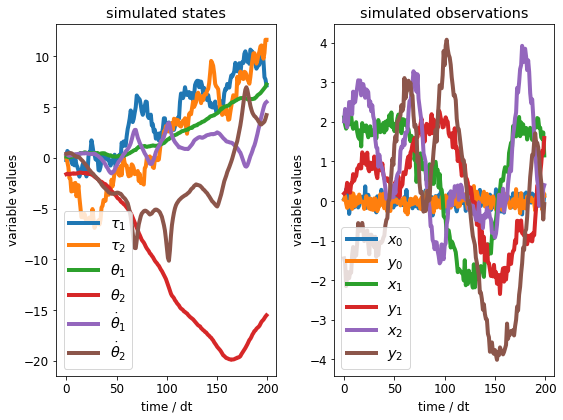

In [26]:
ind_in_batch = 8
plot_simulated_data(lat_data_np, 
                        sim_data_np, 
                        ind_in_batch,
                        label_dict_full,
                       plot_folder + '/sim_dataset.png')

In [27]:
from scipy.special import logsumexp

In [28]:
inference_result = infer_latents(full_model, 
                                 sim_observs, 
                                 num_particles)

run time for 200 timesteps, 64 batches, 1000 particles = 6.90


In [29]:
keys = inference_result.keys()
for key in keys:
    #print(key)
    if type(inference_result[key]) is torch.Tensor:
        inference_result[key] = inference_result[key].cpu()
    elif type(inference_result[key]) is list:
        if len(inference_result[key]) > 0:
            for i in range(len(inference_result[key])):
                inference_result[key][i] = inference_result[key][i].cpu()

In [30]:
# summarize posterior separately for each batch element.
# if batches are identical, each includes an independent SMC sample
posterior_summary = utils_summary.summarize_posterior(inference_result)

applying uniform average of 64 SMC samplers.
applying weighted average of 64 SMC samplers.


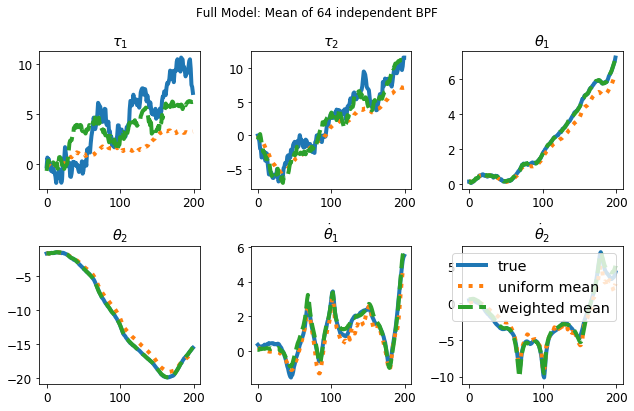

In [34]:
# comparison of uniform and weighted means
# uniform:
mean, var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=None,
    method='uniform')
# weighted:
weighted_mean, weighted_var = utils_summary.summarize_independent_smc_samplers(
    posterior_summary["smooth_mean"],
    posterior_summary["smooth_var"],
    logw=inference_result["log_marginal_likelihood"].detach().numpy(),
    method='weighted',
    remove_indices=None)  # typically better to remove 1/2 dominating indices

# plot the two estimates.
f, axarr = plt.subplots(2, 3, figsize=(9, 6))
axarr = axarr.flatten()
for i in range(lat_data_np.shape[1]):
    axarr[i].plot(lat_data_np[0, i, :], label='true')
    axarr[i].plot(mean[i, :], linestyle='dotted', label='uniform mean')
    axarr[i].plot(weighted_mean[i, :],
                  linestyle='dashed',
                  label='weighted mean')
    axarr[i].set_title(label_dict_full["state"][i])
    if i == lat_data_np.shape[1] - 1:
        plt.legend()
f.suptitle('Full Model: Mean of %i independent BPF' % batch_size)
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(plot_folder + '/mean_of_16_filters_grav.png')

(array([53]),)


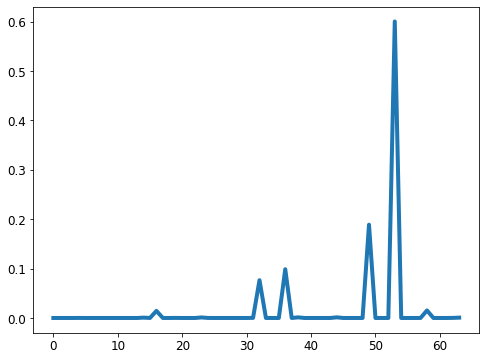

In [35]:
from scipy.special import logsumexp
logw = inference_result["log_marginal_likelihood"].detach().numpy()
w = np.exp(logw - logsumexp(logw))
plt.plot(w)
print(np.where(w==np.max(w)))

In [38]:
np.sort(w) # note that many some w's are == 0. check that in future.

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 3.56862614e-296,
       1.13095717e-130, 2.83661933e-077, 7.92374344e-037, 3.49629611e-024,
       1.93008265e-021, 7.25660232e-017, 8.26016368e-016, 9.86333676e-016,
       1.83310798e-015, 2.77800545e-015, 1.01331061e-014, 9.79146265e-014,
       1.05332060e-012, 4.62679111e-010, 1.30208810e-008, 4.00753624e-008,
       1.51539204e-007, 2.12568508e-007, 1.00717514e-006, 7.95696509e-006,
       3.03843581e-005, 3.09370631e-005, 2.33690420e-004, 2.75845038e-004,
       3.11987381e-004, 3.96458072e-004, 5.70184997e-003, 9.93009466e-001])

In [36]:
#np.where(w==0)
#np.where(np.isin(w, np.sort(w)[-2:])) # which are the two best filters
#np.where(~np.isin(w, np.sort(w)[-2:])) # worst filters

/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt


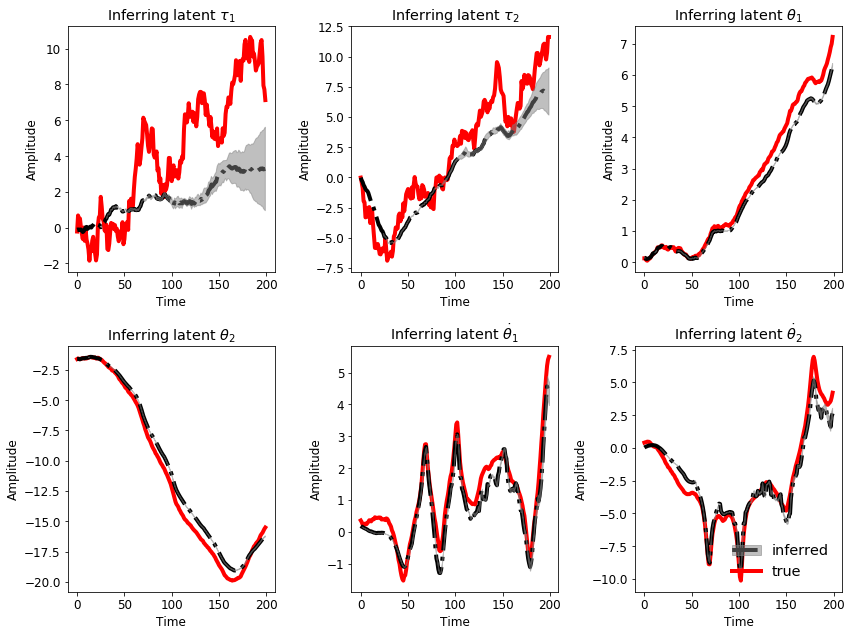

In [37]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/uniform.png'
nrows = 2
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(12, 9),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=mean[i,:],
    post_var=np.sqrt(var[i,:]),
    data_vec=lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt
/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt


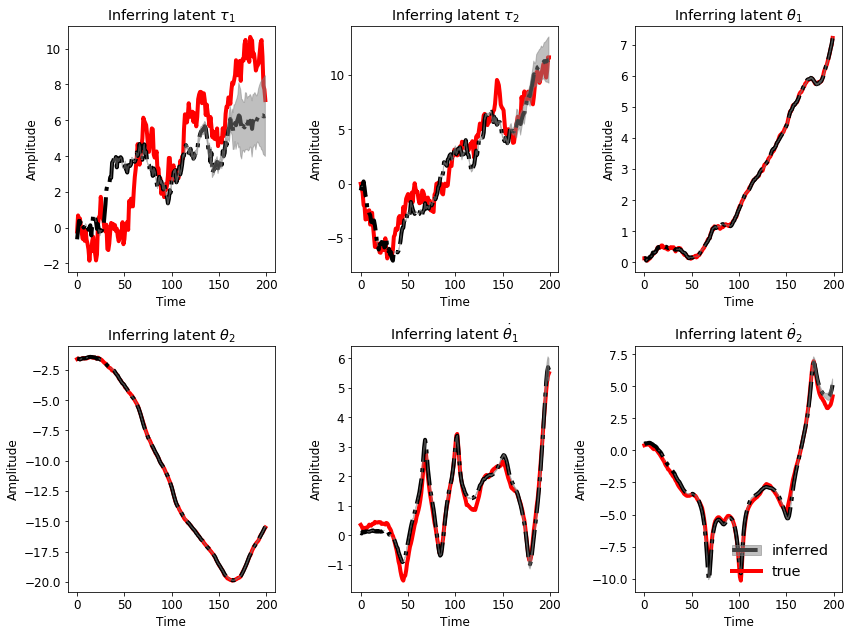

In [38]:
# another version of the plot, incorporating variances.
fig_full_path = plot_folder + '/weighted.png'
nrows = 2
num_latents = lat_data_np.shape[1]
fig, axs = plt.subplots(nrows,
                        int(num_latents / nrows),
                        figsize=(12, 9),
                        sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(weighted_mean.shape[0]):
    if i == num_latents-1:
        plt_leg = True
    arm_utils.plot_posterior_trace(
    post_mean=weighted_mean[i,:],
    post_var=np.sqrt(weighted_var[i,:]),
    data_vec=lat_data_np[ind_in_batch, i, :],
    alpha=0.5,
    plot_legend=plt_leg,
    plot_uncertainty=True,
    plot_true_data=True,
    legends_list=["inferred", "true"],
    legend_loc="lower right",
    title="Inferring latent " + label_dict_full["state"][i],
    xlabel='Time',
    ylabel='Amplitude',
    fig_fullname=None,
    ax=axs[i])
fig.tight_layout()
plt.savefig(fig_full_path)

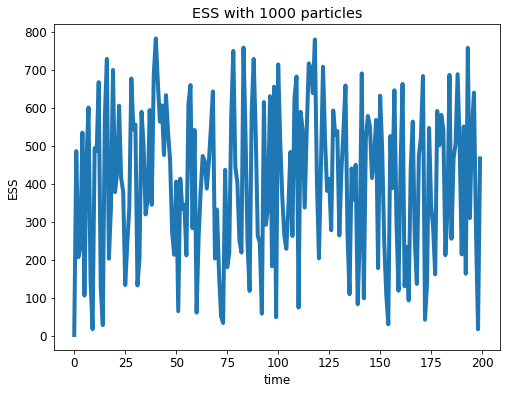

In [39]:
# plot ESS
ind_in_batch = 19
plt.plot(posterior_summary["ESS"][ind_in_batch,:])
plt.xlabel('time')
plt.ylabel('ESS')
plt.title('ESS with %i particles' % num_particles);
plt.savefig(plot_folder+'/ESS_1.png')

In [37]:
## if simulate all the way forward to coords.
#x_obs = sim_data_np[ind_in_batch, [0,2,4], :].T
#y_obs = sim_data_np[ind_in_batch, [1,3,5], :].T
## if simulate only to angles and velocities.
x_obs, y_obs = arm_utils.coords_from_params_mat(
   lat_data_np[ind_in_batch,2,:], 
    lat_data_np[ind_in_batch,3,:], 
                inits_dict["L1"], inits_dict["L2"]) 
print(y_obs.shape)

(200, 3)


In [38]:
# TODO: make sure to input right params for learning
# this is the version for weighted average of BPFs
x_hat , y_hat = arm_utils.coords_from_params_mat(
   weighted_mean[2,:], 
    weighted_mean[3,:], 
                inits_dict["L1"], inits_dict["L2"]) 
x_hat.shape

(200, 3)

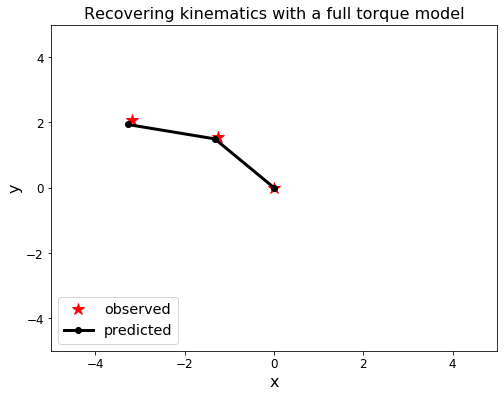

In [39]:
arm_utils.video_sim_plane_2D(x_obs, y_obs, 
                             x_hat, y_hat, 
                             plot_folder+'/recover_dyn', 
                   "Recovering kinematics with a full torque model", 
                             x_hat.shape[0], inits_dict["L1"] + 
                             inits_dict["L2"] + 1)

In [30]:
# tested with functions. it works.
# ToDo: consider building a class that does that.
# give it the inference results and desired K realizations and it'll
# do everything.

k_realizations = 50
smoothing_result = {}  # dict of lists
smoothing_result["normalized_weights"] = []
smoothing_result["latents"] = []
smoothing_result["sampled_indices"] = []

for t in range(num_timesteps - 1, -1, -1):
    if t == num_timesteps - 1:
        normalized_weights = smoothing.expand_normalize_weights(
            inference_result["log_weights"][-1],
            k_realizations)  # Note index -1
        sampled_indices, latents = smoothing.sample_latents(
            normalized_weights, inference_result["latents"][-1])
    else:
        # compute weights
        normalized_weights = smoothing.weight_update(latents,
                                           inference_result["latents"][t],
                                           inference_result["log_weights"][t],
                                           full_model["transition"])

        sampled_indices, latents = smoothing.sample_latents(
            normalized_weights, inference_result["latents"][t])

    # these lists will all be flipped in time
    smoothing_result["normalized_weights"].append(normalized_weights)
    smoothing_result["latents"].append(latents)
    smoothing_result["sampled_indices"].append(sampled_indices)

In [31]:
# flip order
smoothing_result["normalized_weights"] = smoothing_result["normalized_weights"][::-1]
smoothing_result["latents"] = smoothing_result["latents"][::-1]
smoothing_result["sampled_indices"] = smoothing_result["sampled_indices"][::-1]

In [32]:
smoothing_result["latents"][-1].shape
posterior_summary["smooth_mean"].shape

(16, 6, 200)

In [33]:
smooth_traj = torch.cat(
    [smooth.unsqueeze(-1) for smooth in smoothing_result["latents"]], dim=3)
smooth_mean = torch.mean(smooth_traj,
                         dim=0).detach().numpy()  # over trajectories
smooth_var = torch.var(smooth_traj, dim=0).detach().numpy()

In [34]:
smooth_mean.shape
smooth_var.shape

(16, 6, 200)

In [35]:
# if batch elements are identical, take a uniform mean
mean, var = summarize_independent_smc_samplers(
    smooth_mean,
    smooth_var,
    logw=None,
    method='uniform')

applying uniform average of 16 SMC samplers.


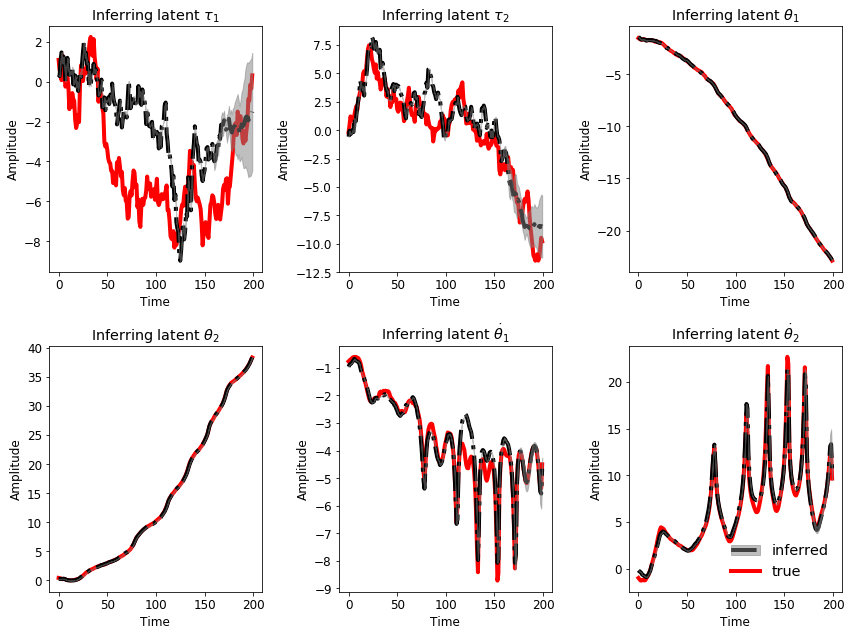

In [36]:
ind_in_batch = 6  # just one batch
fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharey=False)
axs = axs.flatten()
plt_leg = False
for i in range(posterior_summary["smooth_mean"].shape[1]):
    if i == 5:
        plt_leg = True
    arm_utils.plot_posterior_trace(
        post_mean=smooth_mean[ind_in_batch, i, :],
        post_var=np.sqrt(smooth_var[ind_in_batch, i, :]),
        data_vec=lat_data_np[ind_in_batch, i, :],
        alpha=0.5,
        plot_legend=plt_leg,
        plot_uncertainty=True,
        plot_true_data=True,
        legends_list=["inferred", "true"],
        legend_loc="lower right",
        title="Inferring latent " + label_dict_full["state"][i],
        xlabel='Time',
        ylabel='Amplitude',
        fig_fullname=None,
        ax=axs[i])
fig.tight_layout()
plt.savefig(plot_folder + '/FFBS_BPF_infer_latents.png')

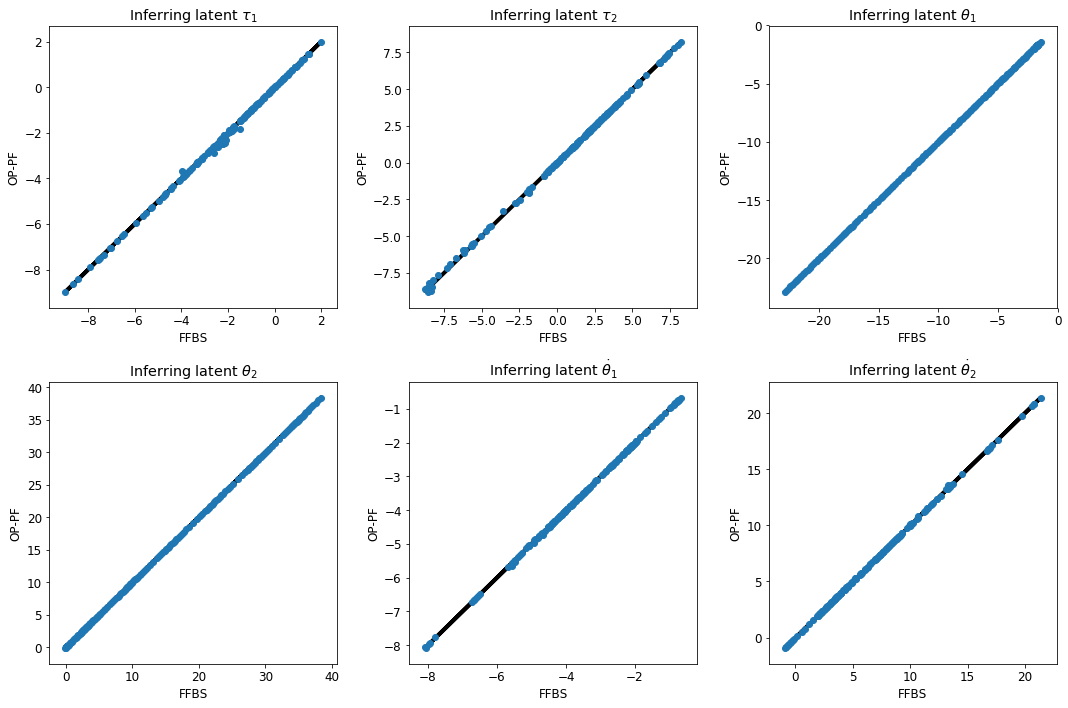

In [38]:
titles = ['$x_{1}$', '$x_{2}$']
plt_leg = False
nrows = 2
fig, axs = plt.subplots(nrows,int(posterior_summary["smooth_mean"].shape[1]/nrows), 
                        figsize = (15,10), sharey=False)
axs = axs.flatten()
for i in range(posterior_summary["smooth_mean"].shape[1]):
    
    if i == 0:
        label = '$x_{1} = f$'
    elif i == 1:
        label = '$x_{2} = x$'
    elif i == 2:
        label = '$x_{3} = \dot{x}$'
        plt_leg = True
    
    axs[i].plot(smooth_mean[ind_in_batch,i,:], 
                smooth_mean[ind_in_batch,i,:], 'k') # diag line
    axs[i].scatter(smooth_mean[ind_in_batch,i,:], 
            posterior_summary["smooth_mean"][ind_in_batch,i,:], 
                   zorder=3)
    axs[i].set_xlabel('FFBS')
    axs[i].set_ylabel('OP-PF')
#     axs[i].plot(filtered_state_means[:,i], color = 'black', linestyle = 'dotted', 
#                 label = 'Kalman filter');
    axs[i].set_title("Inferring latent " +  label_dict_full["state"][i])

fig.tight_layout()
plt.savefig(plot_folder+'/compare_FFBS_BPF.png')

Implement learning of $M_1$ and $M_2$

In [29]:
sim_data_np.shape

(16, 6, 200)

In [35]:
sim_data_np[0, :2, :]

array([[ 5.70418582e-02, -1.26147187e-01,  7.33463124e-02,
        -1.06593631e-03,  2.47888052e-02, -2.22029565e-01,
        -8.18543951e-02, -2.51541028e-01, -8.01100919e-02,
        -2.31288582e-02, -7.02392525e-02, -1.77268907e-01,
         2.89053106e-01,  1.63828490e-02, -1.90669266e-01,
         7.54882909e-02,  1.19438432e-01,  2.13900395e-02,
         3.19796050e-02,  1.90996601e-01,  1.32161615e-01,
         1.18693354e-01,  4.96322846e-02, -5.77234386e-02,
         5.99473435e-02, -7.47436410e-02, -3.49145487e-01,
         3.36627451e-01,  2.93188017e-02,  1.38095598e-01,
         7.88760159e-02, -1.46822371e-02, -1.35461429e-01,
         3.88674974e-01,  1.61835988e-01, -8.74782858e-02,
         1.82245095e-01, -1.15807996e-01, -1.59490798e-01,
        -1.74081084e-01,  2.35196582e-01,  1.15926201e-04,
        -3.71860548e-02,  2.13730724e-01, -3.26950107e-01,
        -1.16073656e-01, -1.65290985e-01, -5.48096284e-02,
        -1.08871898e-01, -2.64580158e-01, -7.58570321e-0

In [44]:
empirical_estimate_L1 = np.linalg.norm(sim_data_np[0, 2:4, :] - sim_data_np[0, :2, :], axis=0)
empirical_estimate_L2 = np.linalg.norm(sim_data_np[0, 4:, :] - sim_data_np[0, 2:4, :], axis=0)

In [48]:
(inits_dict["L1"] - np.median(empirical_estimate_L1)) / inits_dict["L1"]

-0.003617780302634266

In [49]:
(inits_dict["L2"] - np.median(empirical_estimate_L2)) / inits_dict["L2"]

-0.009406472491689799

In [52]:
# look at fw kin learning script for variables, etc.

2.0

In [21]:
learning_inits_dict = {}
learning_inits_dict['L1'] = inits_dict["L1"] + 0.5 # for now, can be empirical estimate or learned
learning_inits_dict['L2'] = inits_dict["L1"] - 0.5 # same
learning_inits_dict['M1'] = inits_dict["M1"] - 0.6 # test init for true == 1.1
learning_inits_dict['M2'] = inits_dict["M2"] + 0.7 # test init for true == 1.1

In [22]:
arm_model_learning = planar_arm_dyn_model.PlanarArmDyn(
    dt=dt,
    inits_dict=learning_inits_dict,
    g=g,
    include_gravity_fictitious=True,
    transform_torques=False,
    learn_static= True)

In [23]:
list(arm_model_learning.parameters())

[Parameter containing:
 tensor(2.5000, requires_grad=True),
 Parameter containing:
 tensor(1.5000, requires_grad=True),
 Parameter containing:
 tensor(0.5000, requires_grad=True),
 Parameter containing:
 tensor(1.9000, requires_grad=True)]

In [24]:
param_dict
# ToDo: there are more params you can add to param dict?

{'init_mu': array([0., 0., 0., 0., 0., 0.]),
 'init_cov': array([[0.5, 0. , 0. , 0. , 0. , 0. ],
        [0. , 0.5, 0. , 0. , 0. , 0. ],
        [0. , 0. , 0.5, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0.5, 0. , 0. ],
        [0. , 0. , 0. , 0. , 0.5, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0.5]])}

In [25]:
learning_model = {}
'''full_model includes arm dynamics, and FW-KIN emission.
here we learn M1 and M2'''

learning_model["initial"] = planar_arm_dyn_model.Initial(param_dict["init_mu"],
                                                     param_dict["init_cov"])

learning_model["transition"] = planar_arm_dyn_model.Transition(
    dt, transition_force_scale, transition_aux_scale, arm_model_learning)

learning_model["emission"] = planar_arm_dyn_model.Emission(learning_inits_dict,
                                                       np.eye(6) *
                                                       emission_var_diag,
                                                        arm_model_learning,
                                                       theta_indices=[2, 3])

learning_model["proposal"] = planar_arm_dyn_model.Bootstrap_Proposal( \
                               learning_model["initial"], learning_model["transition"])

In [26]:
# running params
num_timesteps = 100
saving_interval = 10
logging_interval = 1
batch_size = 32 # 64 is good for independent SMC. the higher the better.
num_iterations = 30
num_particles = 500
num_epochs = 40

In [27]:
dataloader = train.get_synthetic_dataloader(
            full_model["initial"],
            full_model["transition"],
            full_model["emission"],
            num_timesteps, batch_size)

In [28]:
# ToDo: look at the aesmc original script for training
training_stats = planar_arm_dyn_model.TrainingStats(true_inits_dict=inits_dict,
                arm_model_instance = arm_model_learning,
                num_timesteps = num_timesteps,
                logging_interval = logging_interval)

In [30]:
arm_model_learning.to("cuda")

PlanarArmDyn()

In [ ]:
# just for now, but should be set . no need to run. can change defs here
for param in list(arm_model_learning.parameters()):
    parm.requires_grad = True
print(list(arm_model_learning.parameters()))

In [31]:
from scipy.special import logsumexp

In [32]:
train.train(dataloader=dataloader,
            num_particles=num_particles,
            algorithm='aesmc',
            initial=learning_model["initial"],
            transition=learning_model["transition"],
            emission=learning_model["emission"],
            proposal=learning_model["proposal"],
            num_epochs=num_epochs,
            num_iterations_per_epoch=num_iterations,
            callback=training_stats)

each batch contains different data.
Epoch 0: Iteration 0: Loss = 2345.128165477906, Param. norm = 1.1616523068128346
each batch contains different data.
Epoch 0: Iteration 1: Loss = 2272.076158025878, Param. norm = 1.1591385412898503
each batch contains different data.
Epoch 0: Iteration 2: Loss = 1524.5450813996445, Param. norm = 1.1569021509991104
each batch contains different data.
Epoch 0: Iteration 3: Loss = 2396.791745459028, Param. norm = 1.1538503314550685
each batch contains different data.
Epoch 0: Iteration 4: Loss = 1799.8589302755197, Param. norm = 1.1515446509227707
each batch contains different data.
Epoch 0: Iteration 5: Loss = 1355.7506243092957, Param. norm = 1.149988703303553
each batch contains different data.
Epoch 0: Iteration 6: Loss = 1645.7278546609498, Param. norm = 1.1488134728777917
each batch contains different data.
Epoch 0: Iteration 7: Loss = 1468.253359870863, Param. norm = 1.1475734747116464
each batch contains different data.
Epoch 0: Iteration 8: Los

Epoch 2: Iteration 9: Loss = 2009.6877176873286, Param. norm = 1.128291427574524
each batch contains different data.
Epoch 2: Iteration 10: Loss = 2841.3948115070416, Param. norm = 1.1282648192486346
each batch contains different data.
Epoch 2: Iteration 11: Loss = 1455.905269358385, Param. norm = 1.1282453973303486
each batch contains different data.
Epoch 2: Iteration 12: Loss = 1814.176070415222, Param. norm = 1.128218915330478
each batch contains different data.
Epoch 2: Iteration 13: Loss = 1656.8386084890099, Param. norm = 1.1281996910570196
each batch contains different data.
Epoch 2: Iteration 14: Loss = 1733.3274384475303, Param. norm = 1.128166081118455
each batch contains different data.
Epoch 2: Iteration 15: Loss = 1725.4823486049368, Param. norm = 1.1281173944280622
each batch contains different data.
Epoch 2: Iteration 16: Loss = 1641.4119270742717, Param. norm = 1.1280450710971794
each batch contains different data.
Epoch 2: Iteration 17: Loss = 2123.1095971977766, Para

Epoch 4: Iteration 18: Loss = 1061.4226046200818, Param. norm = 1.1232958717951713
each batch contains different data.
Epoch 4: Iteration 19: Loss = 1820.3758407869823, Param. norm = 1.12328817022719
each batch contains different data.
Epoch 4: Iteration 20: Loss = 2194.706323001917, Param. norm = 1.1232641999968493
each batch contains different data.
Epoch 4: Iteration 21: Loss = 1231.442393262295, Param. norm = 1.1232178909101305
each batch contains different data.
Epoch 4: Iteration 22: Loss = 1927.9528170247145, Param. norm = 1.1231719315276358
each batch contains different data.
Epoch 4: Iteration 23: Loss = 1222.7961834668708, Param. norm = 1.1231185570803601
each batch contains different data.
Epoch 4: Iteration 24: Loss = 1714.7735498057577, Param. norm = 1.1230499900760462
each batch contains different data.
Epoch 4: Iteration 25: Loss = 1278.62619948138, Param. norm = 1.122934214661638
each batch contains different data.
Epoch 4: Iteration 26: Loss = 1487.0961437048536, Param

Epoch 6: Iteration 27: Loss = 1318.5735330330274, Param. norm = 1.1188786623093105
each batch contains different data.
Epoch 6: Iteration 28: Loss = 1933.6505619926631, Param. norm = 1.118742194937635
each batch contains different data.
Epoch 6: Iteration 29: Loss = 1652.069683743197, Param. norm = 1.1186135776948598
each batch contains different data.
each batch contains different data.
Epoch 7: Iteration 0: Loss = 1784.3698812896973, Param. norm = 1.118474184656722
each batch contains different data.
Epoch 7: Iteration 1: Loss = 2045.8567570025039, Param. norm = 1.118334855352293
each batch contains different data.
Epoch 7: Iteration 2: Loss = 646.223583276415, Param. norm = 1.1182023029139556
each batch contains different data.
Epoch 7: Iteration 3: Loss = 1181.5814065075726, Param. norm = 1.1180643402230754
each batch contains different data.
Epoch 7: Iteration 4: Loss = 1202.6459889958933, Param. norm = 1.1179249323609184
each batch contains different data.
Epoch 7: Iteration 5: L

Epoch 9: Iteration 6: Loss = 1005.7217773825698, Param. norm = 1.1207126969828904
each batch contains different data.
Epoch 9: Iteration 7: Loss = 839.0169762820603, Param. norm = 1.1206622320198711
each batch contains different data.
Epoch 9: Iteration 8: Loss = 1875.8800872257984, Param. norm = 1.1206246035242522
each batch contains different data.
Epoch 9: Iteration 9: Loss = 1144.6334942586568, Param. norm = 1.1205821082125438
each batch contains different data.
Epoch 9: Iteration 10: Loss = 1665.3396067417523, Param. norm = 1.1205350039272366
each batch contains different data.
Epoch 9: Iteration 11: Loss = 1442.9560906159427, Param. norm = 1.1204848192521335
each batch contains different data.
Epoch 9: Iteration 12: Loss = 1149.8070297469164, Param. norm = 1.120432540076244
each batch contains different data.
Epoch 9: Iteration 13: Loss = 1000.8915295538363, Param. norm = 1.1203870349037637
each batch contains different data.
Epoch 9: Iteration 14: Loss = 1453.6469200366955, Para

Epoch 11: Iteration 15: Loss = 1186.159031291635, Param. norm = 1.1136628904159391
each batch contains different data.
Epoch 11: Iteration 16: Loss = 968.0872253111596, Param. norm = 1.113645665913202
each batch contains different data.
Epoch 11: Iteration 17: Loss = 968.6961140067247, Param. norm = 1.1136175291871142
each batch contains different data.
Epoch 11: Iteration 18: Loss = 1130.3786592077904, Param. norm = 1.1135819300144572
each batch contains different data.
Epoch 11: Iteration 19: Loss = 1540.9983404498216, Param. norm = 1.113538512438803
each batch contains different data.
Epoch 11: Iteration 20: Loss = 2666.4590980932717, Param. norm = 1.1134917042467705
each batch contains different data.
Epoch 11: Iteration 21: Loss = 1034.4430353127573, Param. norm = 1.1134408474693651
each batch contains different data.
Epoch 11: Iteration 22: Loss = 1217.733614271467, Param. norm = 1.1133891299956205
each batch contains different data.
Epoch 11: Iteration 23: Loss = 1071.7897265803

Epoch 13: Iteration 24: Loss = 1372.7908335025209, Param. norm = 1.1077372011375906
each batch contains different data.
Epoch 13: Iteration 25: Loss = 1236.3040118283147, Param. norm = 1.1076941428800315
each batch contains different data.
Epoch 13: Iteration 26: Loss = 1019.2253646513469, Param. norm = 1.107648990812969
each batch contains different data.
Epoch 13: Iteration 27: Loss = 1425.216486662849, Param. norm = 1.107595258515972
each batch contains different data.
Epoch 13: Iteration 28: Loss = 1405.8313212261605, Param. norm = 1.1075337773494183
each batch contains different data.
Epoch 13: Iteration 29: Loss = 1968.860704022241, Param. norm = 1.1074703373972252
each batch contains different data.
each batch contains different data.
Epoch 14: Iteration 0: Loss = 1156.3671702874126, Param. norm = 1.107403831382534
each batch contains different data.
Epoch 14: Iteration 1: Loss = 859.398865988347, Param. norm = 1.1073413719765492
each batch contains different data.
Epoch 14: Ite

Epoch 16: Iteration 2: Loss = 663.0655356880834, Param. norm = 1.102841230020276
each batch contains different data.
Epoch 16: Iteration 3: Loss = 1812.8525539264924, Param. norm = 1.102780845606137
each batch contains different data.
Epoch 16: Iteration 4: Loss = 1119.4342934625201, Param. norm = 1.1027513303076433
each batch contains different data.
Epoch 16: Iteration 5: Loss = 1484.8715864333892, Param. norm = 1.1027198304157033
each batch contains different data.
Epoch 16: Iteration 6: Loss = 1592.1240898844512, Param. norm = 1.1026791140446026
each batch contains different data.
Epoch 16: Iteration 7: Loss = 2219.9989791642806, Param. norm = 1.1026343107120045
each batch contains different data.
Epoch 16: Iteration 8: Loss = 1233.9702704935767, Param. norm = 1.1025813525608825
each batch contains different data.
Epoch 16: Iteration 9: Loss = 1711.7109974707544, Param. norm = 1.102188908572331
each batch contains different data.
Epoch 16: Iteration 10: Loss = 1314.1071831167772, P

Epoch 18: Iteration 11: Loss = 1228.0394489960026, Param. norm = 1.076734002354725
each batch contains different data.
Epoch 18: Iteration 12: Loss = 1558.5363512753247, Param. norm = 1.0766382135101686
each batch contains different data.
Epoch 18: Iteration 13: Loss = 1123.0798390731118, Param. norm = 1.0765441384658834
each batch contains different data.
Epoch 18: Iteration 14: Loss = 1594.8871953075568, Param. norm = 1.076456271258515
each batch contains different data.
Epoch 18: Iteration 15: Loss = 1637.9990764105728, Param. norm = 1.0763752849914174
each batch contains different data.
Epoch 18: Iteration 16: Loss = 864.0025178949447, Param. norm = 1.0763000476321753
each batch contains different data.
Epoch 18: Iteration 17: Loss = 1219.8802815869344, Param. norm = 1.07622572600374
each batch contains different data.
Epoch 18: Iteration 18: Loss = 1290.535058907419, Param. norm = 1.0761531616640296
each batch contains different data.
Epoch 18: Iteration 19: Loss = 1241.0836583555

Epoch 20: Iteration 20: Loss = 1428.09419398833, Param. norm = 1.0740340815578928
each batch contains different data.
Epoch 20: Iteration 21: Loss = 1174.516356081762, Param. norm = 1.0739623083899508
each batch contains different data.
Epoch 20: Iteration 22: Loss = 919.8647907048396, Param. norm = 1.07389334327758
each batch contains different data.
Epoch 20: Iteration 23: Loss = 965.7859601897765, Param. norm = 1.073825142897904
each batch contains different data.
Epoch 20: Iteration 24: Loss = 878.5492745906042, Param. norm = 1.0737518018530403
each batch contains different data.
Epoch 20: Iteration 25: Loss = 1197.441269874692, Param. norm = 1.073685921046773
each batch contains different data.
Epoch 20: Iteration 26: Loss = 849.4824005647757, Param. norm = 1.0736231271603045
each batch contains different data.
Epoch 20: Iteration 27: Loss = 1824.577256161289, Param. norm = 1.0735505431566525
each batch contains different data.
Epoch 20: Iteration 28: Loss = 869.0040966485403, Par

Epoch 22: Iteration 29: Loss = 847.8006806206267, Param. norm = 1.0626328497354989
each batch contains different data.
each batch contains different data.
Epoch 23: Iteration 0: Loss = 802.0897665137759, Param. norm = 1.062481494747345
each batch contains different data.
Epoch 23: Iteration 1: Loss = 999.7854977722182, Param. norm = 1.0623558681243934
each batch contains different data.
Epoch 23: Iteration 2: Loss = 925.2958583497016, Param. norm = 1.0622465499308338
each batch contains different data.
Epoch 23: Iteration 3: Loss = 1281.982253160431, Param. norm = 1.0621529048929823
each batch contains different data.
Epoch 23: Iteration 4: Loss = 611.5333328355865, Param. norm = 1.0620748212819482
each batch contains different data.
Epoch 23: Iteration 5: Loss = 537.0237524622519, Param. norm = 1.0619966635027347
each batch contains different data.
Epoch 23: Iteration 6: Loss = 1358.6765061685203, Param. norm = 1.0619199366554617
each batch contains different data.
Epoch 23: Iteration

Epoch 25: Iteration 8: Loss = 1167.684451101165, Param. norm = 1.05898217411079
each batch contains different data.
Epoch 25: Iteration 9: Loss = 1478.0332348610705, Param. norm = 1.0588786653621567
each batch contains different data.
Epoch 25: Iteration 10: Loss = 779.3810138644817, Param. norm = 1.0587815931138653
each batch contains different data.
Epoch 25: Iteration 11: Loss = 1188.0300810446201, Param. norm = 1.0586941096475517
each batch contains different data.
Epoch 25: Iteration 12: Loss = 713.0248348746718, Param. norm = 1.0586139830718415
each batch contains different data.
Epoch 25: Iteration 13: Loss = 893.7524898946185, Param. norm = 1.058517569578661
each batch contains different data.
Epoch 25: Iteration 14: Loss = 1176.3022208974508, Param. norm = 1.0584267031987928
each batch contains different data.
Epoch 25: Iteration 15: Loss = 961.0697004338994, Param. norm = 1.0583487186878593
each batch contains different data.
Epoch 25: Iteration 16: Loss = 1206.0827438940569,

Epoch 27: Iteration 17: Loss = 503.9495926472408, Param. norm = 1.054685476316188
each batch contains different data.
Epoch 27: Iteration 18: Loss = 961.835211661504, Param. norm = 1.0546330944950713
each batch contains different data.
Epoch 27: Iteration 19: Loss = 828.0158223974238, Param. norm = 1.0545757931313184
each batch contains different data.
Epoch 27: Iteration 20: Loss = 1365.33890092509, Param. norm = 1.0545127898224893
each batch contains different data.
Epoch 27: Iteration 21: Loss = 1621.5343861367314, Param. norm = 1.0544469687903122
each batch contains different data.
Epoch 27: Iteration 22: Loss = 629.0632520723989, Param. norm = 1.0543821457650557
each batch contains different data.
Epoch 27: Iteration 23: Loss = 404.69944906804017, Param. norm = 1.05432090875795
each batch contains different data.
Epoch 27: Iteration 24: Loss = 870.0430533485394, Param. norm = 1.0542555266872877
each batch contains different data.
Epoch 27: Iteration 25: Loss = 1920.9176885741063, 

Epoch 29: Iteration 26: Loss = 636.6493463878287, Param. norm = 1.0510798260096583
each batch contains different data.
Epoch 29: Iteration 27: Loss = 887.7389079923287, Param. norm = 1.051146514035289
each batch contains different data.
Epoch 29: Iteration 28: Loss = 933.3868598487545, Param. norm = 1.051181982459039
each batch contains different data.
Epoch 29: Iteration 29: Loss = 759.1625253119066, Param. norm = 1.051193953136894
each batch contains different data.
each batch contains different data.
Epoch 30: Iteration 0: Loss = 1071.7439939595843, Param. norm = 1.0511736405215293
each batch contains different data.
Epoch 30: Iteration 1: Loss = 1288.8787860291854, Param. norm = 1.0511357960330319
each batch contains different data.
Epoch 30: Iteration 2: Loss = 518.352713122709, Param. norm = 1.051091045260296
each batch contains different data.
Epoch 30: Iteration 3: Loss = 794.4060059662411, Param. norm = 1.0510483567885789
each batch contains different data.
Epoch 30: Iteration

Epoch 32: Iteration 5: Loss = 803.368386712774, Param. norm = 1.0597487622490733
each batch contains different data.
Epoch 32: Iteration 6: Loss = 822.7138293433783, Param. norm = 1.0599743557139625
each batch contains different data.
Epoch 32: Iteration 7: Loss = 486.4258518648118, Param. norm = 1.0601325747668187
each batch contains different data.
Epoch 32: Iteration 8: Loss = 1707.6383195097217, Param. norm = 1.060237414385206
each batch contains different data.
Epoch 32: Iteration 9: Loss = 678.0055039457895, Param. norm = 1.0602965166463114
each batch contains different data.
Epoch 32: Iteration 10: Loss = 1044.0693487888464, Param. norm = 1.0603285444046948
each batch contains different data.
Epoch 32: Iteration 11: Loss = 999.1321643533079, Param. norm = 1.0603399390168555
each batch contains different data.
Epoch 32: Iteration 12: Loss = 891.9150026416794, Param. norm = 1.0603431923735551
each batch contains different data.
Epoch 32: Iteration 13: Loss = 864.7963490826639, Par

Epoch 34: Iteration 14: Loss = 560.7078977484665, Param. norm = 1.0618477167578406
each batch contains different data.
Epoch 34: Iteration 15: Loss = 732.8227672609412, Param. norm = 1.0619855358420864
each batch contains different data.
Epoch 34: Iteration 16: Loss = 780.9787409354466, Param. norm = 1.0620798375566989
each batch contains different data.
Epoch 34: Iteration 17: Loss = 819.1189246861475, Param. norm = 1.0621374794441056
each batch contains different data.
Epoch 34: Iteration 18: Loss = 830.3168921427523, Param. norm = 1.0621350646750078
each batch contains different data.
Epoch 34: Iteration 19: Loss = 637.9048586292045, Param. norm = 1.062109213368039
each batch contains different data.
Epoch 34: Iteration 20: Loss = 885.765532370105, Param. norm = 1.0620810093413051
each batch contains different data.
Epoch 34: Iteration 21: Loss = 750.9514028629925, Param. norm = 1.0620498346079341
each batch contains different data.
Epoch 34: Iteration 22: Loss = 545.9428677466426, 

Epoch 36: Iteration 23: Loss = 482.2400136509555, Param. norm = 1.0602181552519905
each batch contains different data.
Epoch 36: Iteration 24: Loss = 770.8677247519735, Param. norm = 1.0601241155379177
each batch contains different data.
Epoch 36: Iteration 25: Loss = 879.4137948220822, Param. norm = 1.0600346143653172
each batch contains different data.
Epoch 36: Iteration 26: Loss = 953.325099729771, Param. norm = 1.0600853161967179
each batch contains different data.
Epoch 36: Iteration 27: Loss = 1339.3149366918767, Param. norm = 1.0601658196645476
each batch contains different data.
Epoch 36: Iteration 28: Loss = 841.1705367465266, Param. norm = 1.060211510579908
each batch contains different data.
Epoch 36: Iteration 29: Loss = 1698.9351457487517, Param. norm = 1.06023542064539
each batch contains different data.
each batch contains different data.
Epoch 37: Iteration 0: Loss = 1115.4823825986505, Param. norm = 1.0602442356222284
each batch contains different data.
Epoch 37: Iter

Epoch 39: Iteration 2: Loss = 587.1525800021293, Param. norm = 1.0435125580455584
each batch contains different data.
Epoch 39: Iteration 3: Loss = 1610.0461834177102, Param. norm = 1.0434890021415062
each batch contains different data.
Epoch 39: Iteration 4: Loss = 710.7943188230649, Param. norm = 1.043468607834949
each batch contains different data.
Epoch 39: Iteration 5: Loss = 513.1736017474136, Param. norm = 1.0434431681592724
each batch contains different data.
Epoch 39: Iteration 6: Loss = 733.8261707376774, Param. norm = 1.0434146508162776
each batch contains different data.
Epoch 39: Iteration 7: Loss = 969.335780815008, Param. norm = 1.0433887702423668
each batch contains different data.
Epoch 39: Iteration 8: Loss = 1613.8482024007683, Param. norm = 1.0433891407151998
each batch contains different data.
Epoch 39: Iteration 9: Loss = 493.575750058101, Param. norm = 1.0433939705842898
each batch contains different data.
Epoch 39: Iteration 10: Loss = 810.8590335800789, Param. 

In [33]:
training_stats.curr_params_list

[array([2.49700022, 1.49699986, 0.49700004, 1.89699984]),
 array([2.49400926, 1.49793363, 0.4989669 , 1.89731312]),
 array([2.49107742, 1.49938333, 0.50068009, 1.89818633]),
 array([2.488065  , 1.50084352, 0.50290495, 1.89820015]),
 array([2.4851253 , 1.50281751, 0.50551438, 1.90007496]),
 array([2.48240852, 1.50460708, 0.50689256, 1.90183008]),
 array([2.47966623, 1.50586808, 0.50735027, 1.90305948]),
 array([2.47681284, 1.50688112, 0.50774562, 1.90401912]),
 array([2.47378564, 1.50753689, 0.50755501, 1.90464509]),
 array([2.47074509, 1.50797939, 0.50734842, 1.90505576]),
 array([2.46790624, 1.50833714, 0.50741404, 1.90537548]),
 array([2.4668138 , 1.50765264, 0.50564218, 1.90488935]),
 array([2.4658637 , 1.50678515, 0.50434196, 1.90419471]),
 array([2.46639371, 1.50420797, 0.50180221, 1.90163028]),
 array([2.46706963, 1.50164759, 0.49926013, 1.8990767 ]),
 array([2.4672091 , 1.49973607, 0.49735665, 1.89717078]),
 array([2.4668169 , 1.49832559, 0.49593547, 1.89576614]),
 array([2.4659

In [34]:
params = np.asarray(training_stats.curr_params_list)
print(params)

[[2.49700022 1.49699986 0.49700004 1.89699984]
 [2.49400926 1.49793363 0.4989669  1.89731312]
 [2.49107742 1.49938333 0.50068009 1.89818633]
 ...
 [2.16396403 1.48020077 0.50613308 1.86156929]
 [2.16436934 1.4805733  0.50662583 1.86199868]
 [2.16406298 1.48040545 0.5069297  1.8618288 ]]


In [47]:
list(inits_dict.keys())[0]

'L1'

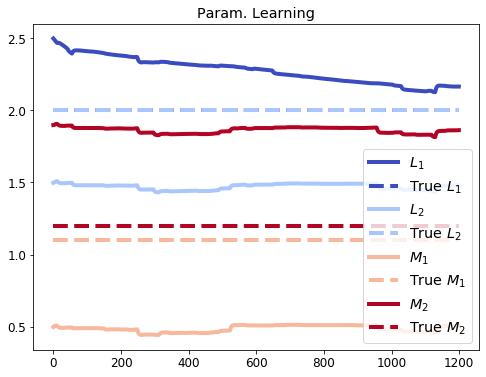

In [56]:
from matplotlib.pyplot import cm
param_label_list = [r"$L_1$", r"$L_2$", r"$M_1$", r"$M_2$"]
key_list = list(inits_dict.keys())
color=iter(cm.coolwarm(np.linspace(0,1,len(key_list))))
for i in range(params.shape[1]):
    c = next(color)
    plt.plot(params[:,i], label = param_label_list[i], c=c)
    plt.plot([0, len(params)], [inits_dict[key_list[i]], inits_dict[key_list[i]]], \
                                label = "True " + param_label_list[i],
            linestyle = "dashed", c=c)
plt.legend()
plt.title("Param. Learning")
plt.savefig(plot_folder + '/param_learning.png')

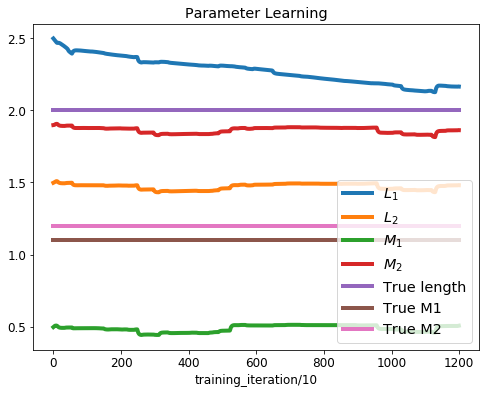

In [43]:
plt.title('Parameter Learning')
plt.plot(params[:,0], label = r"$L_1$")
plt.plot(params[:,1], label = r"$L_2$")
plt.plot(params[:,2], label = r"$M_1$")
plt.plot(params[:,3], label = r"$M_2$")
plt.plot([0, len(params)], [2.0, 2.0], label = "True length")
plt.plot([0, len(params)], [inits_dict["M1"], inits_dict["M1"]], label = "True M1")
plt.plot([0, len(params)], [inits_dict["M2"], inits_dict["M2"]], label = "True M2")

plt.xlabel('training_iteration/10')
plt.legend()

$M_1 : = 1, M_2 = \lambda \cdot M_1$ 
since we can init $L$ properly from observations, maybe fix $L$'s and $M_1$ -- can we infer $M_2$?
If this becomes hard, just fix all params and ignore the learning problem.

In [49]:
L1_in_training  = np.zeros(len(training_stats.curr_params_list))
L2_in_training  = np.zeros(len(training_stats.curr_params_list))

for i in range(len(training_stats.curr_params_list)):
    L1_in_training[i] = training_stats.curr_params_list[i][0]
    L2_in_training[i] = training_stats.curr_params_list[i][1]

NameError: name 'L1_in_training' is not defined

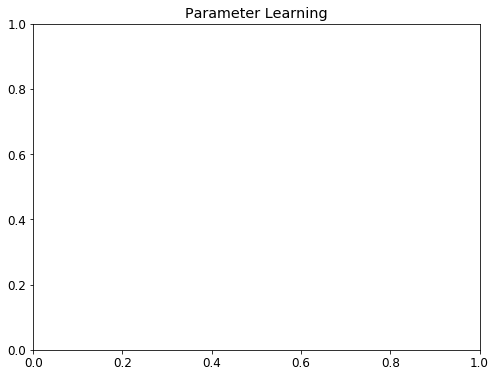

In [57]:
plt.title('Parameter Learning')
plt.plot(L1_in_training, label = r"$L_1$")
plt.plot(L2_in_training, label = r"$L_2$")
plt.plot([0, len(L1_in_training)], [2.0, 2.0], 'k', label = "True length")
plt.xlabel('training_iteration/10')
plt.legend()

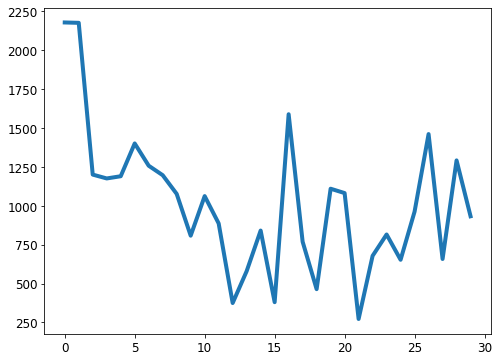

In [56]:
plt.plot(training_stats.loss)

In [61]:
list(arm_model_learning.parameters())

[Parameter containing:
 tensor(2.0476, device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(1.9407, device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(2., device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(1.2000, device='cuda:0', requires_grad=True)]

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [62]:
learning_model["transition"].to(device)

Transition(
  (arm_model): PlanarArmDyn()
)

In [57]:
type(learning_model["transition"])

arm_models.planar_arm_dyn_model.Transition

In [64]:
learning_model["transition"].diag_mat.device

device(type='cpu')

In [65]:
torch.cuda.empty_cache()

In [70]:
list(learning_model["transition"].parameters())

[Parameter containing:
 tensor(0.7084, device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor(1.5079, device='cuda:0', requires_grad=True)]

In [69]:
learning_model["transition"].cuda()

Transition(
  (arm_model): PlanarArmDyn()
)

In [72]:
learning_model["transition"].diag_mat.to(device)

tensor([[0.3600, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3600, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0013, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0013, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0013, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0013]], device='cuda:0',
       dtype=torch.float64)